# Create Null Models for our Valorant Network
## Imports

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
%matplotlib inline

## Import the links

In [2]:
df =  pd.read_csv("../Data/Main-Data/links.csv")
df

,Source,Target,Weight
0,224,81,3
1,224,1578,3
2,224,2006,3
3,224,1715,3
4,224,104,3
...,...,...,...
24071,3674,3675,1
24072,3674,3681,1
24073,3674,3682,1
24074,3674,3683,1


## Create the graph using Network X

In [3]:
G = nx.from_pandas_edgelist(df, source='Source', target="Target", edge_attr='Weight')

print("Nodes: " + str(G.number_of_nodes()))
print("Edges: " + str(G.number_of_edges()))

Nodes: 2642
Edges: 22571


## This code was taken from CPSC 572 Tutorials
- Basically plots the degree distribution

In [4]:
# Function to plot a degree distribution graph (P(k) vs k graph)
def plot_degree_dist(G):
    
    degrees = [G.degree(n) for n in G.nodes()]
    kmin = min(degrees)
    kmax = max(degrees)
    
    if kmin>0:
        bin_edges = np.logspace(np.log10(kmin), np.log10(kmax)+1, num=20)
    else:
        bin_edges = np.logspace(0, np.log10(kmax)+1, num=20)
    density, _ = np.histogram(degrees, bins=bin_edges, density=True)

    fig = plt.figure(figsize=(6,4))

    log_be = np.log10(bin_edges)
    x = 10**((log_be[1:] + log_be[:-1])/2)
    plt.loglog(x, density, marker='o', linestyle='none')
    plt.xlabel(r"degree $k$", fontsize=16)
    plt.ylabel(r"$P(k)$", fontsize=16)

    ax = plt.gca()
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

## We plot the existing degree distribution

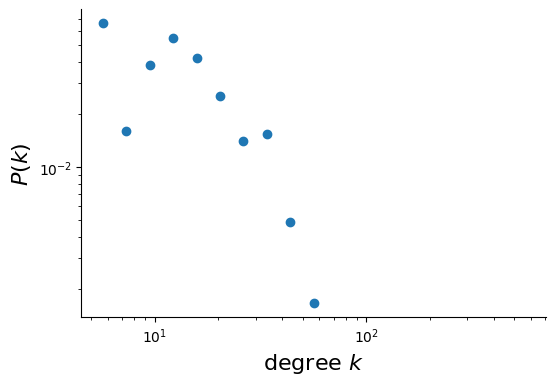

In [5]:
plot_degree_dist(G)

## Calculate the average Clustering Coefficient and Shortest Path
## We also get the largest partition here.

In [6]:
largestComponent = None
maxNodeSize = 0

for C in (G.subgraph(c).copy() for c in nx.connected_components(G)):
    averageSPT = nx.average_shortest_path_length(C, weight=True)
    averageClustering = np.mean(list(nx.clustering(C).values()))
    
    if(C.number_of_nodes() > maxNodeSize):
        largestComponent = C
        maxNodeSize = C.number_of_nodes()

    print("Average Clustering Coefficient: ", averageClustering)
    print("Average Shortest Path: ", averageSPT)

print("Largest Component Nodes: " + str(largestComponent.number_of_nodes()))
print("Largest Component Links: " + str(largestComponent.number_of_edges()))


Average Clustering Coefficient:  0.12099893881066047
Average Shortest Path:  7.491242113581576
Average Clustering Coefficient:  0.0
Average Shortest Path:  1.4444444444444444
Average Clustering Coefficient:  0.0
Average Shortest Path:  2.745061728395062
Average Clustering Coefficient:  0.0
Average Shortest Path:  1.6323529411764706
Average Clustering Coefficient:  0.0
Average Shortest Path:  1.736842105263158
Average Clustering Coefficient:  0.0
Average Shortest Path:  1.736842105263158
Average Clustering Coefficient:  0.0
Average Shortest Path:  1.4444444444444444
Average Clustering Coefficient:  0.0
Average Shortest Path:  1.7142857142857142
Largest Component Nodes: 2463
Largest Component Links: 21767


## Calculations for ER graph
- We get the number nodes for our largest component
- We calculate the max links you can have with the nodes
- We calculate our existing probability of connection

In [7]:
GN = len(largestComponent.nodes())                  # Get the number of nodes in the largest Component
max_links = GN*(GN-1)/2                                 # Max Links
actual_links = len(largestComponent.edges())            # Number of links in largestComponent
p = actual_links/max_links                                  # Calculate probability

## Create 1000 instances of the ER graph
- Here it says 10, but our Average and STD was calculated on a much faster computer for 1000 instances.
- ETA: 1.5 hours for 1000 instances.
- Estimated Runtime: 1.5 hours
- Run time specs:
    - 5.0Ghz 9th gen intel processor.

In [8]:
# ER Graph
clustering_ER = []
short_path_ER = []
for i in range(10): # 1000 is better
    erdos_renyi = nx.erdos_renyi_graph(GN, p, directed=True)                                    # Generate ER network with fixed num nodes and p
    averageClustering_ER = np.mean(list(nx.clustering(erdos_renyi).values()))                   # Get the average clustering
    if nx.is_weakly_connected(erdos_renyi) == True:                                                    # If ER is weakly connected (as long as it has 1 directed arrow)
        averageShortestPath_ER = nx.average_shortest_path_length(erdos_renyi, weight=None)      #   Get the average shortest path
        short_path_ER.append(averageShortestPath_ER)                                                # Append to list
    clustering_ER.append(averageClustering_ER)                                                  # Append to list

    print(i)        # For running status


print("ER - Average Clustering " + str(np.mean(clustering_ER)))
print("ER - Standard Deviation for Clustering " + str(np.std(clustering_ER)))

print("ER - Average Shortest Path " + str(np.mean(short_path_ER)))
print("ER - Standard Deviation for Shortest Path " + str(np.std(short_path_ER)))

0
1
2
3
4
5
6
7
8
9
ER - Average Clustering 0.0072045921946904175
ER - Standard Deviation for Clustering 8.579504079540265e-05
ER - Average Shortest Path 2.986931014431952
ER - Standard Deviation for Shortest Path 0.003988508512998036


## Degree Preserving Random Networkd
- We copy our largest component and perform edge swaps on those.
- We ignore the weights of the graph as it was recommended to us by the professor.
- Estimated Runtime: 1.5 hours for 1000 graphs
- Run time specs:
    - 5.0Ghz 9th gen intel processor.

In [9]:
DP = largestComponent.copy()                    # Copy the existing graph because we want to just swap edges.

max_tries = 750000  # 10*largestComponent.number_of_edges()  * 3
ensemble_size = 10  # Stats were ran on a much faster computer for 1000 graphs. 1000 is better
clustering_DP = []
short_path_DP = []

for i in range(ensemble_size): 
    nx.double_edge_swap(DP, nswap=10*largestComponent.number_of_edges(), max_tries=max_tries)       # Swaps the edges
    averageClustering_DP = np.mean(list(nx.clustering(DP).values()))                                # Calculate the average Clustering
    if nx.is_connected(DP) == True:                                                          # If the graph is weakly connected          
        averageShortestPath_DP = nx.average_shortest_path_length(DP, weight=None)                   # Calculate the Average Shortest Path
        short_path_DP.append(averageShortestPath_DP)                                        # If the TA is reading this, there's a bug in Real World, should only append when it's able to calculate shorted path.
    clustering_DP.append(averageClustering_DP)                                                      # Append average clustering
    print(i)            # For running status


print("DP - Average Clustering " + str(np.mean(clustering_DP)))
print("DP - Standard Deviation for Clustering " + str(np.std(clustering_DP)))

print("DP - Average Shortest Path " + str(np.mean(short_path_DP)))
print("DP - Standard Deviation for Shortest Path " + str(np.std(short_path_DP)))

0
1
2
3
4
5
6
7
8
9
DP - Average Clustering 0.014049289337806711
DP - Standard Deviation for Clustering 0.00031126848666035087
DP - Average Shortest Path 2.9861662103601208
DP - Standard Deviation for Shortest Path 0.0015527633103576731
